In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

from fastprogress import master_bar, progress_bar
from fastai.vision import *
from fastai.distributed import *
from fastai.metrics import accuracy
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.nn as nn
#import pretrainedmodels
import math
import sys
import pickle

from arch import GeM, L2Norm
%config InlineBackend.figure_format ='retina'

SEED = 42
np.random.seed(SEED), random.seed(SEED), torch.random.manual_seed(SEED), torch.cuda.manual_seed_all(SEED)

(None, None, <torch._C.Generator at 0x7f4fd31b90b0>, None)

In [2]:
path = Path('../google-landmark-train/')
train_df = pd.read_csv(path / 'train.csv', usecols=[0,2], converters={'id':lambda x:x[0]+'/'+x[1]+'/'+x[2]+'/'+x})
train_df.head()
min_images, n_landmarks = 200, 1000
train_df = train_df.groupby('landmark_id').filter(lambda x: len(x) >= min_images)

In [3]:
train_df = train_df[train_df['landmark_id'].isin(
    np.random.choice(train_df['landmark_id'].unique(), n_landmarks, replace=False))]

In [4]:
train_df.head()

,id,landmark_id
1,2/0/2/202cd79556f30760,104169
9,8/d/f/8df019949b8db328,81049
11,c/c/f/ccf070a2da242d56,138982
23,0/5/3/053d1409647dfba2,74821
25,3/c/d/3cdc355c6232712f,12877


In [5]:
train_df['landmark_id'].nunique()

1000

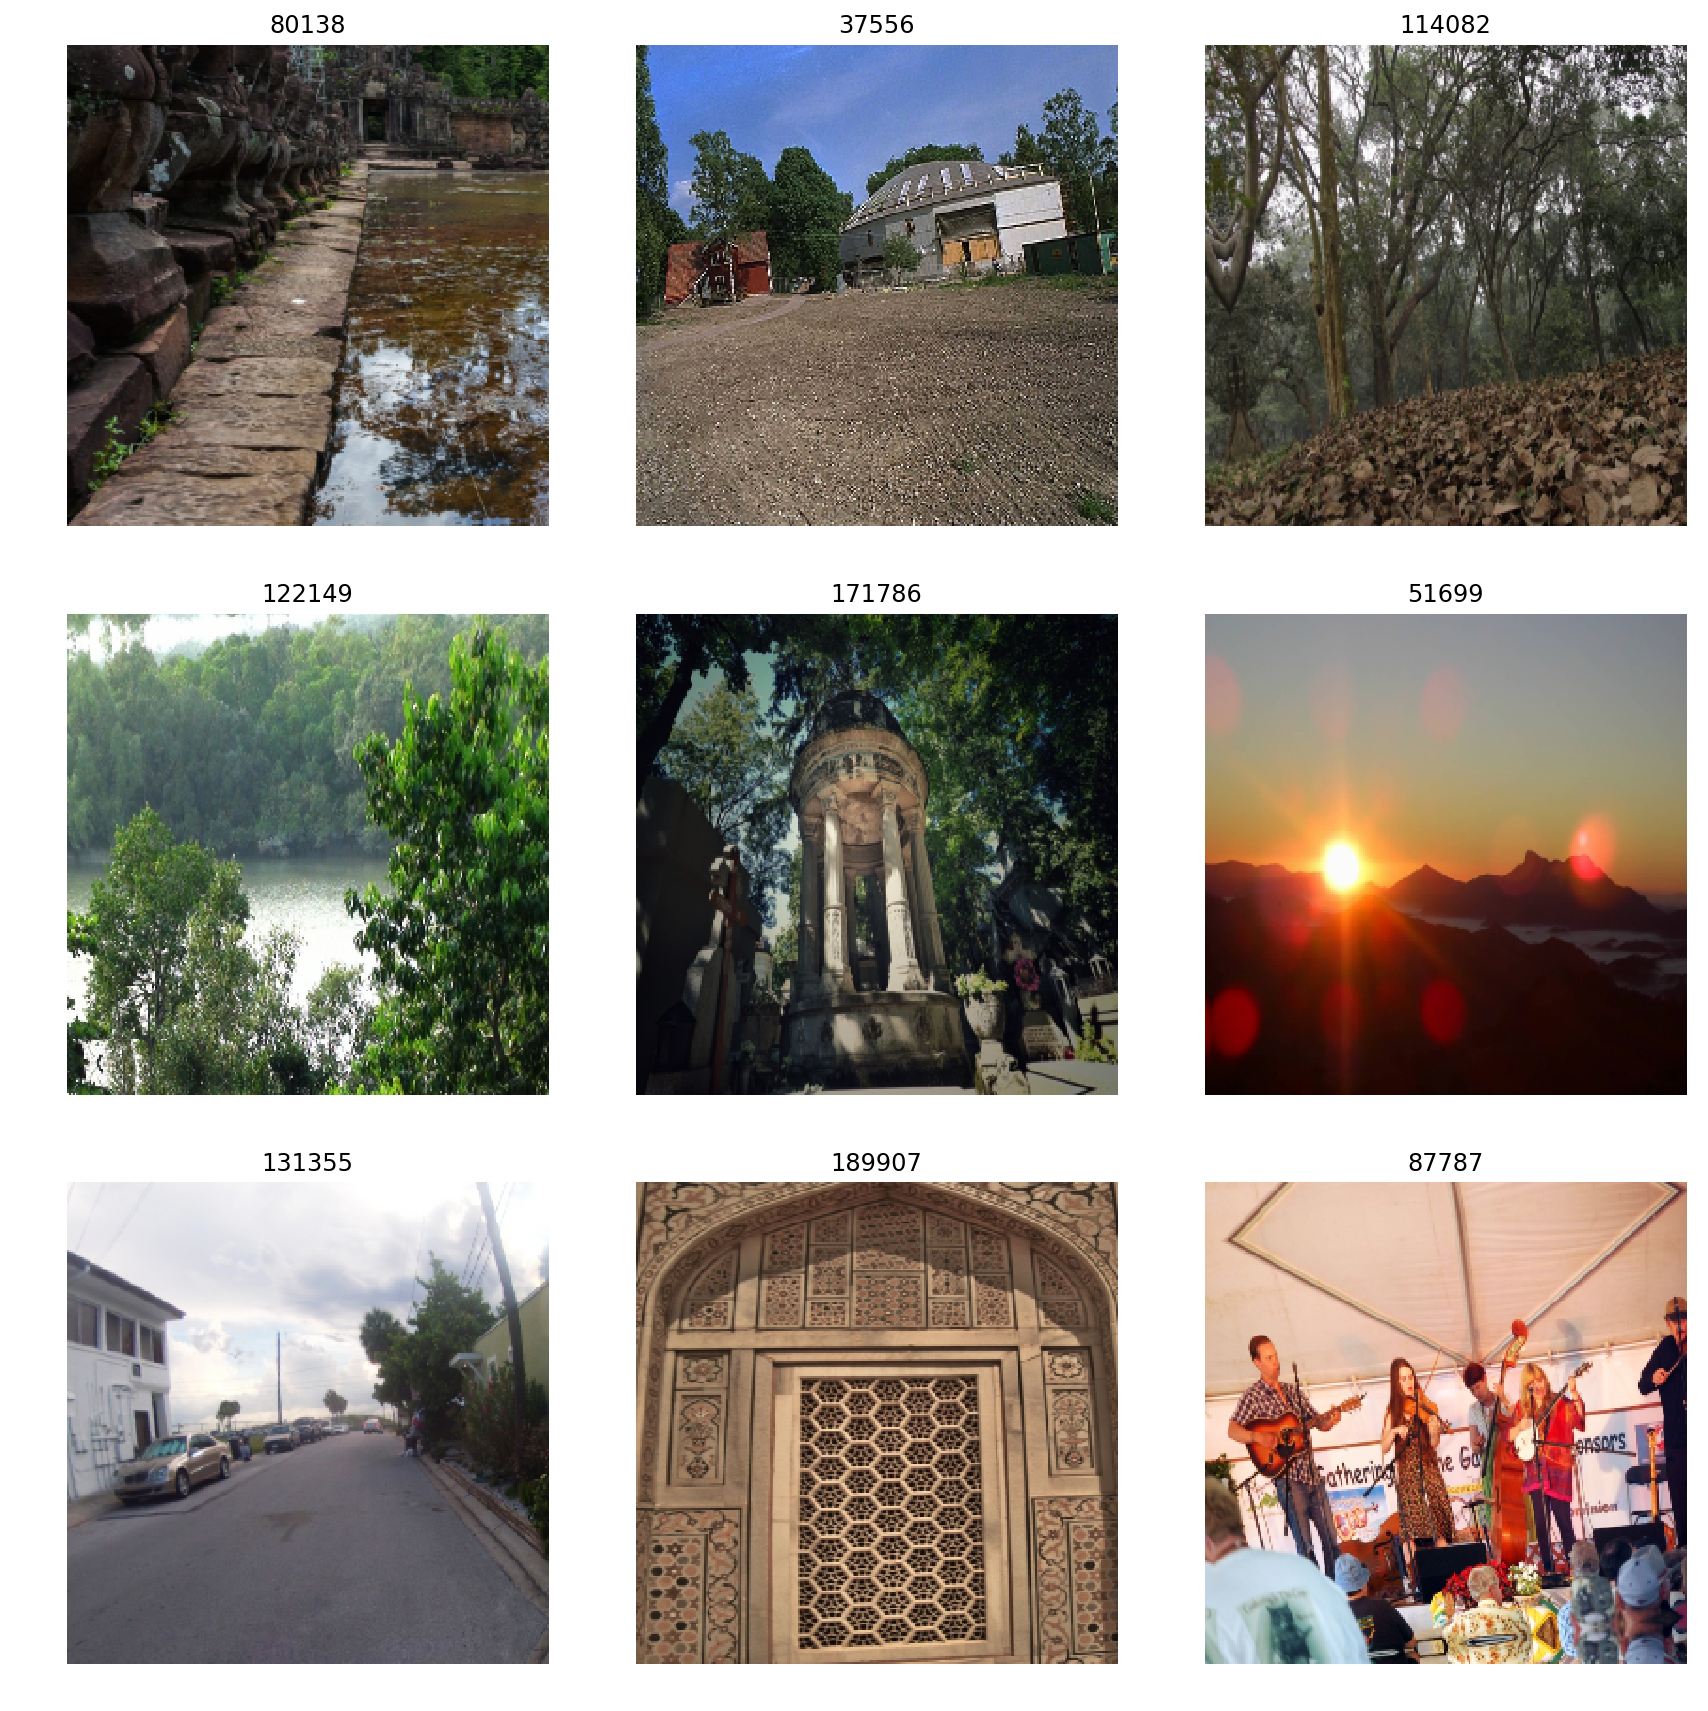

In [6]:
SZ = 256
BS = 48
NUM_WORKERS = 16

data = (ImageList
        .from_df(train_df, path, suffix='.jpg')
        .split_by_rand_pct(0.2, seed=SEED)
        .label_from_df('landmark_id')
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='')
       ).normalize(imagenet_stats)

data.show_batch(rows=3)

In [7]:
NUM_CLASSES= len(data.classes)
print (NUM_CLASSES)

1000


In [8]:
arch = models.resnet152
model_name = f'{arch.__name__}_i{min_images}_l{n_landmarks}-{SZ}'

In [9]:
archcut = nn.Sequential(
    *list(arch(pretrained=True).children())[:-2], nn.AdaptiveAvgPool2d(1),Flatten(), nn.Linear(2048, NUM_CLASSES))

In [10]:
learn = None
gc.collect()
torch.cuda.empty_cache()
#learn = cnn_learner(data, arch, pretrained=False, metrics=[accuracy], lin_ftrs=[], concat_pool=False)
learn = Learner(data, archcut,  metrics=[accuracy])

In [11]:
learn.model
#previous_model_name = 'resnet50_i200_l1000-256'

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [12]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
______________________________________________________________

In [13]:
try:
    learn = learn.load(previous_model_name)
    print(f"Loaded {previous_model_name}")
except:
    pass

In [14]:
learn = learn.mixup().to_fp16().to_parallel()

In [15]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False),
 functools.partial(<class 'fastai.callbacks.mixup.MixUpCallback'>, alpha=0.4, stack_x=False, stack_y=True)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


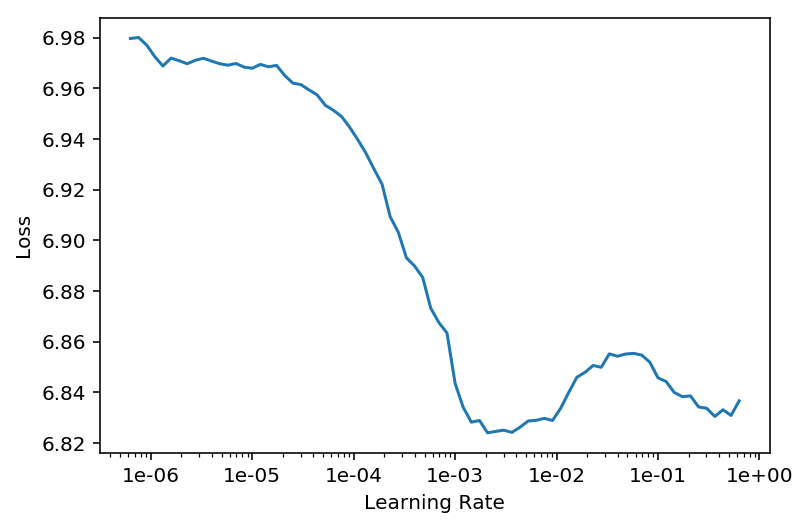

In [17]:
learn.data.batch_size = 142
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.867955,2.841974,0.410358,23:33
1,3.829314,2.814571,0.423531,23:30
2,3.609632,2.634808,0.459081,23:27
3,3.368752,2.319270,0.509803,23:29
4,3.086349,1.969825,0.580718,23:30
5,2.861970,1.818876,0.614910,23:28
6,2.648319,1.634275,0.648423,23:31
7,2.449796,1.448500,0.687996,23:27
8,2.295806,1.341226,0.711039,23:30
9,2.134656,1.203660,0.739730,23:26


In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
model_name = f'{arch.__name__}_i{min_images}_l{n_landmarks}-{SZ}'
learn.save(model_name)
previous_model_name = model_name


In [ ]:
previous_model_name